<a href="https://colab.research.google.com/github/ArturoAA95/TransmisionProblem/blob/main/OptimizedTwoRegimes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Numerical Libraries.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from random import randint
import sys
import os
import scipy
from scipy import optimize
from scipy.sparse.linalg import spsolve

#Operator

In [ ]:
def H(a1, a2, a3, a4):
  return min(a1, a2, a3, a4) + 1

def S(a1, a2, a3, a4):
  return .25*(a1+a2+a3+a4)


#Fast Marching Method.

In [ ]:
import heapq
#om: A rectangular domain omega with labels 1,2,3 and 4.
  # 1 and 2 correspond to the eikonal part
#dist: Initialized matrix of distances to the boundary
def FastMarchingMethod(om, dist, N): #Solves Eikonal equation
  #Inicialice narrow band
  NB = []
  for i in range(N):
    for j in range(N):
      if om[i, j] > 0 and om[i, j] < 3: #Run over eikonal
        if om[i+1, j] == 0 or om[i-1, j] == 0: #Check if one of up and down neihbors is in the boundary
          aux = H(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1])
        elif om[i, j+1] == 0 or om[i, j-1] == 0: #Check if one of left and right neihbors is in the boundary
          aux = H(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1])
        else:
          continue  #The index is not added to the narrow band
        new_dist = np.copy(aux)
        if new_dist < dist[i, j]:
          dist[i, j] = new_dist
          x = [i, j]
          heapq.heappush(NB, (new_dist, x))
  #Compute Eikonal solution
  #Loop until narrow band is empty
  while len(NB)>0 :
    #Pop the element with the least distance in the narrow band
    c_dist, c_vert = heapq.heappop(NB)
    i = int(c_vert[0])
    j = int(c_vert[1])
    #The vertex (i,j) becomes a boundary point
    om[i, j] = 0
    # Check if we have already poped the vertex
    if c_dist > dist[i, j]:
      continue
    #Update distance for neighbors of current_vertex
    #Update the distance of the neighbor upwards
    if om[i+1, j] > 0 and om[i+1, j] < 3: #Restrict to Eikonal
      i_aux = i+1
      j_aux = j
      aux = H(dist[i_aux+1, j_aux], dist[i_aux-1, j_aux], dist[i_aux, j_aux+1], dist[i_aux, j_aux-1])
      new_dist = np.copy(aux)
      #Only update if the distance is smaller than the current distance
      if new_dist < dist[i_aux, j_aux]:
        dist[i_aux, j_aux] = new_dist
        y = [i_aux, j_aux]
        heapq.heappush(NB, (new_dist, y))
    #Update the distance of the neighbor downwards
    if om[i-1, j] > 0 and om[i-1, j] < 3: #Restrict to Eikonal
      i_aux = i-1
      j_aux = j
      aux = H(dist[i_aux+1, j_aux], dist[i_aux-1, j_aux], dist[i_aux, j_aux+1], dist[i_aux, j_aux-1])
      new_dist = np.copy(aux)
      #Only update if the distance is smaller than the current distance
      if new_dist < dist[i_aux, j_aux]:
        dist[i_aux, j_aux] = new_dist
        y = [i_aux, j_aux]
        heapq.heappush(NB, (new_dist, y))
    #Update the distance of the neighbor to the right
    if om[i, j+1] > 0 and om[i, j+1] < 3: #Restrict to Eikonal
      i_aux = i
      j_aux = j+1
      aux = H(dist[i_aux+1, j_aux], dist[i_aux-1, j_aux], dist[i_aux, j_aux+1], dist[i_aux, j_aux-1])
      new_dist = np.copy(aux)
      #Only update if the distance is smaller than the current distance
      if new_dist < dist[i_aux, j_aux]:
        dist[i_aux, j_aux] = new_dist
        y = [i_aux, j_aux]
        heapq.heappush(NB, (new_dist, y))
    #Update the distance of the neighbor to the left
    if om[i, j-1] > 0 and om[i, j-1] < 3: #Restrict to Eikonal
      i_aux = i
      j_aux = j-1
      aux = H(dist[i_aux+1, j_aux], dist[i_aux-1, j_aux], dist[i_aux, j_aux+1], dist[i_aux, j_aux-1])
      new_dist = np.copy(aux)
      #Only update if the distance is smaller than the current distance
      if new_dist < dist[i_aux, j_aux]:
        dist[i_aux, j_aux] = new_dist
        y = [i_aux, j_aux]
        heapq.heappush(NB, (new_dist, y))
  return dist


#Construction of the domain (T)

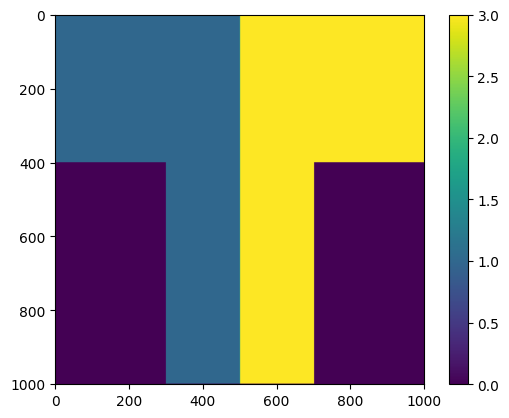

In [ ]:
#N= 101             # Dimension of the box, N=2k+1
#Iy = int(N/2)   # y-coordinate of the interface
#vT = 30         # Height of top interior of T
#hT = 27          # Wide of bottom half of T in Brownian zone

#N= 101             # Dimension of the box, N=2k+1
#Iy = int(N/2)   # y-coordinate of the interface
#vT = 45         # Height of top interior of T
#hT = 25          # Wide of bottom half of T in Brownian zone

#N= 201             # Dimension of the box, N=2k+1
#Iy = int(N/2)   # y-coordinate of the interface
#vT = 90         # Height of top interior of T
#hT = 50          # Wide of bottom half of T in Brownian zone

#N=251    #500 iteraciones 2.5 min
#Iy= int(N/2)
#vT= 100
#hT= 50

#N=501    #500 iteraciones 10 min, 1^-5
#Iy= int(N/2)
#vT= 200
#hT= 100

N=1001    #500 iteraciones 2.5 min
Iy= int(N/2)
vT= 400
hT= 200


#We give codes to each region of the domain
# 0 -> Fixed point (Boundary and non-used)
# 1 -> Eikonal
# 2 -> Interface
# 3 -> Brownian

#Eikonal
om = np.zeros((N,N))
for i in range(0,vT):
  for j in range(1,Iy):
    om[i+1,j] = 1
for i in range(vT,N-1):
  for j in range(Iy-hT,Iy):
    om[i,j] = 1

#Interface
for i in range(1,N-1):
  om[i,Iy] = 2

#Brownian
for i in range(0,vT):
  for j in range(Iy+1,N-1):
    om[i+1,j] = 3
for i in range(vT,N-1):
  for j in range(Iy+1,Iy+hT+1):
    om[i,j] = 3

plt.imshow(om)
plt.colorbar()

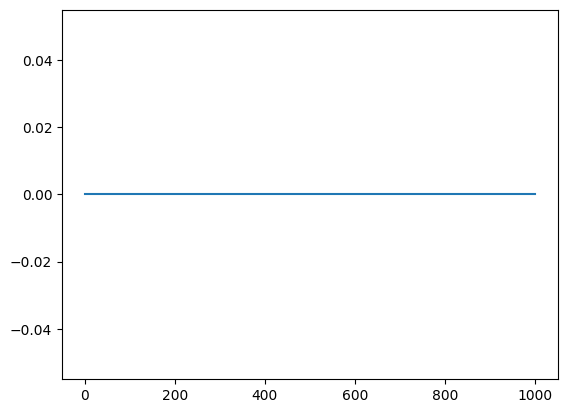

In [ ]:
plt.plot(om[1000,:])

#Eikonal test

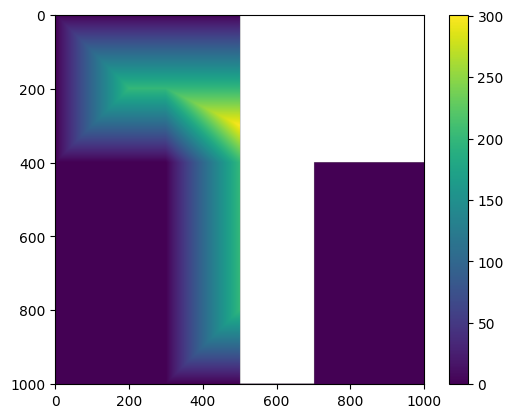

In [ ]:
Omega = np.copy(om)                             ### We preserve the structure of the domain in om

#Initialize distances with 0 in the boundary, and +infinity everywhere else
dist = np.zeros((N,N))
for i in range(N):
  for j in range(N):
    if Omega[i, j]>0:
      dist[i, j] = np.inf

eik_0 = FastMarchingMethod(Omega, dist, N)        ### Omega is modified
plt.imshow(eik_0)
plt.colorbar()



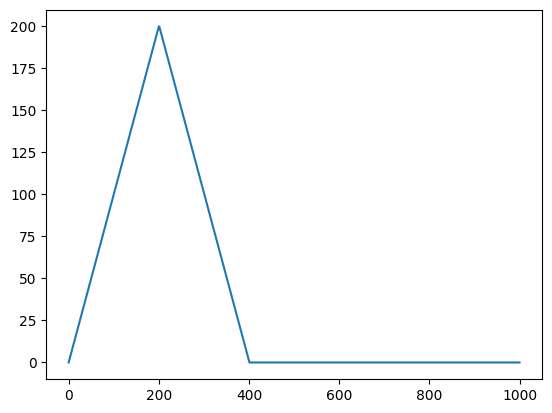

In [ ]:
plt.plot(eik_0[:,290])

#Construction of Laplacian operator

In [ ]:
from scipy import sparse

#Give coordinates and receive position in vector
def Coord_to_Pos(x, y, N, Iy, vT, hT):
  if x < (vT+1):
    l = (Iy-1)*(x-1) + (y-Iy-1)
  if x > vT:
    l_0 = (Iy-1)*vT
    l = l_0 + hT*(x-vT-1) + (y-Iy-1)
  return l

#Give position in vector and receive coordinates
def Pos_to_Coord(l, N, Iy, vT, hT):
  if l < ((Iy-1)*vT):
    y = Iy+1+l%(Iy-1)
    x = int(l/(Iy-1)) + 1
  if l>=((Iy-1)*vT):
    l = l - ((Iy-1)*vT)
    x_0 = vT + 1
    y = Iy+1+l%hT
    x = x_0 + int(l/hT)
  return x,y

# Compute dimension of vector b
dim = 0
for i in range(N):
  for j in range(N):
    if om[i,j] == 3:
      dim = dim + 1

#Create Matrix for system to solve Laplace equation

A = sparse.csr_matrix((dim, dim))
A = A.tolil()

#Construct linear system for the Brownian region
for l in range(dim):
  A[l,l] = -4
  x, y = Pos_to_Coord(l, N, Iy, vT, hT)
  #Check if (x,y) has a neighbor to the left
  if y > (Iy+1):
    A[l, l-1] = 1
  #Check if (x,y) has a neighbor upwards
  if x > 1 and x <= (vT+1):
    A[l, l-(Iy-1)] = 1
  if x > (vT+1):
    A[l, l-hT] = 1
  #Check if (x,y) has a neighbor to the right
  if x <= vT and y < N-2:
    A[l, l+1] = 1
  if x > vT and y < (Iy+hT):
    A[l, l+1] = 1
  #Check if (x,y) has a neighbor downwards
  if x == vT and y <= (Iy+hT):
    A[l, l+(Iy-1)] = 1
  if x > vT and x < (N-2):
    A[l, l+hT] = 1
  if x < vT:
    A[l, l+(Iy-1)] = 1

A = A.tocsr()


#Updating b and updating solution in the domain

In [ ]:
#Receives current solution and modifies the boundary values for the Brownian region using the interface
def Actualiza_b(sol, dim, Iy, vT, hT, N):
  b = np.zeros(dim)
  for l in range(dim):
    x, y = Pos_to_Coord(l, N, Iy, vT, hT)
    if y == Iy+1:
      b[l] = -sol[x, Iy]
  return b

#Receives vector obtained when solving Laplaces equation and copies it to the solution matrix
def Actualiza_sol(sol, dim, Iy, vT, hT, N, sol_brow):
  for l in range(dim):
    x , y = Pos_to_Coord(l, N, Iy, vT, hT)
    sol[x, y] = sol_brow[l]
  return sol

#Determine the strategy given the cost function

In [ ]:
#Strategy determines one strategy according to the value function sol
# 3 -> Move Up
# 2 -> Move Left
# 1 -> Move Down
# 4 -> Move Right

def Strategy(N, sol, omega):
  stra = np.zeros((N, N))
  for i in range(N-1):
    for j in range(N):
      # Run over the eikonal region (where the player has control):
      # om[i, j] == 1,2
      if omega[i, j] > 0 and omega[i, j] < 3:
        # Find neighbor with the smallest value function
        stra[i, j] = 1 #Initial assumption: the smallest value is up
        smallest = sol[i+1, j]
        aux = sol[i, j-1]  #Compare with left
        if smallest > aux: #Update strategy left
          smallest = aux
          stra[i, j] = 2
        aux = sol[i-1, j]   #Compare with down
        if smallest > aux: #Update strategy down
          smallest = aux
          stra[i, j] = 3
        aux = sol[i, j+1]  #Compare with right
        if smallest > aux: #Update strategy right
          smallest = aux
          stra[i, j] = 4
  return stra

#Change in the region with the strategy to utilize the random region
def RandomStrategyChange(Strategy1, Strategy2, N):
  #g1 = [(i,j) for i in range(N-1) for j in range(N) if Strategy1[i,j] == 4 and Strategy1[i,j] != Strategy2[i,j]]
  #g2 = [(i,j) for i in range(N-1) for j in range(N) if Strategy2[i,j] == 4 and Strategy2[i,j] != Strategy1[i,j]]
  g1 = np.count_nonzero(Strategy1==4)
  return g1



#Test A, Update_b, and Update_Sol

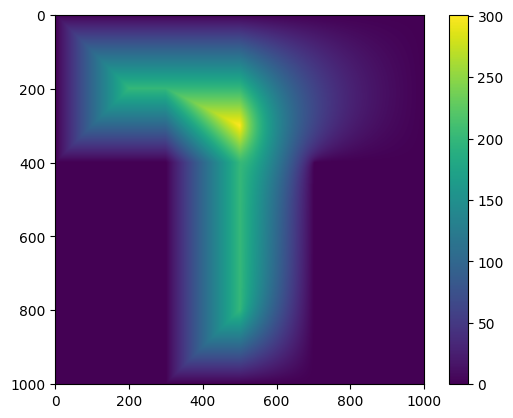

In [ ]:
#Initialize solution
b = Actualiza_b(eik_0, dim, Iy, vT, hT, N)
x = spsolve(A, b)
sol = Actualiza_sol(eik_0, dim, Iy, vT, hT, N, x)
plt.imshow(sol)
plt.colorbar()
st = np.copy(sol)

for i in range(1, N-1):
  om[i,Iy] = 2

#Initialize the strategy
est0 = Strategy(N, sol, om)

#plt.imshow(est0)
#plt.colorbar()

#Solver

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

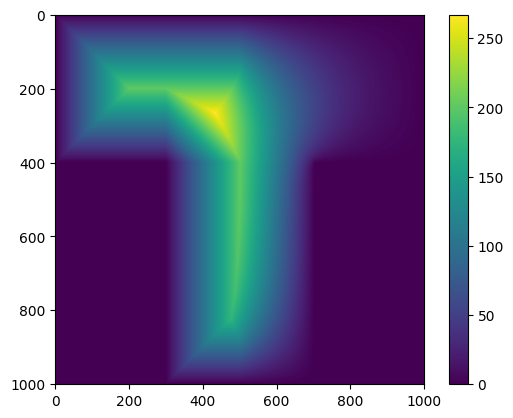

In [ ]:
#Fix the interphase
for j in range(1,N-1):
  om[j,Iy] = 0

def Solve_One_Player_T_Strategy(omega, sol_0, iter, dim, Iy, vT, hT, N, A, est_0, l1, l2):
  #Copy the initial strategy
  aux_est = np.copy(est_0)
  strat = np.zeros(iter)
  err = np.zeros(iter)
  val_a = np.zeros(iter)
  val_b = np.zeros(iter)
  #Iterate over iter
  for k in range(iter):
    print(k)
    #Update interphase and compute error
    error = 0
    for j in range(1,N-1):
      a_1 = sol_0[j, Iy+1]
      a_2 = sol_0[j, Iy-1]
      a_3 = sol_0[j+1, Iy]
      a_4 = sol_0[j-1, Iy]
      aux1 = H(a_1, a_2, a_3, a_4)
      aux2 = S(a_1, a_2, a_3, a_4)
      aux_error1 = np.abs(sol_0[j,Iy]-aux1)
      aux_error2 = np.abs(sol_0[j,Iy]-aux2)
      aux_error = min(aux_error1, aux_error2)
      if sol_0[j, Iy] > aux1:
        sol_0[j, Iy] = aux1
      if aux_error > error:
        error = aux_error
    #Save information of the domain
    om = np.copy(omega)
    #Solve in the Eikonal region
    sol_0 = FastMarchingMethod(om, sol_0, N)
    #Update the boundary for the Brownian region
    b = Actualiza_b(sol_0, dim, Iy, vT, hT, N)
    #Solve Laplace equation in Brownian region
    sol_brow = spsolve(A, b)
    #Update solution
    sol_0 = Actualiza_sol(sol_0, dim, Iy, vT, hT, N, sol_brow)
    for i in range(1, N-1):
      om[i,Iy] = 2
    #Update strategy
    est = Strategy(N, sol_0, om)
    #Compute errors
    g1 = RandomStrategyChange(est, aux_est, N)
    strat[k] = g1
    err[k] = error
    val_a[k] = sol_0[l1, Iy]
    val_b[k] = sol_0[l2, Iy]
    aux_est = np.copy(est)
  return sol_0, strat, err, val_a, val_b

vv, change_strat, err, val1, val2= Solve_One_Player_T_Strategy(om, sol, 1000, dim, Iy, vT, hT,N,A, est0, 300, 800)
plt.imshow(vv)
plt.colorbar()

In [ ]:
# prompt: save vv in a file and download it to my computer as a numpy file
vv, change_strat, err, val1, val2
import numpy as np
np.save('vv.npy', vv)
np.save('change_strat.npy', change_strat)
np.save('err.npy', err)
np.save('val1.npy', val1)
np.save('val2.npy', val2)
from google.colab import files
files.download('vv.npy')
files.download('change_strat.npy')
files.download('err.npy')
files.download('val1.npy')
files.download('val2.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Error.

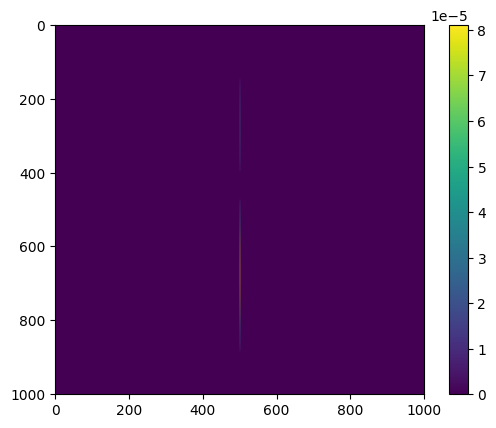

In [ ]:
for i in range(1,N-1):
  om[i,Iy] = 2
error = np.zeros((N,N))
for i in range(N):
  for j in range(N):
    if om[i,j]>0 and om[i,j]<3:
      a_1 = vv[i,j+1]
      a_2 = vv[i,j-1]
      a_3 = vv[i+1,j]
      a_4 = vv[i-1,j]
      error[i,j] = np.abs(vv[i,j]-min(a_1,a_2,a_3,a_4)-1)
    if om[i,j]==3:
      a_1 = vv[i,j+1]
      a_2 = vv[i,j-1]
      a_3 = vv[i+1,j]
      a_4 = vv[i-1,j]
      error[i,j] = np.abs((.25)*(4*vv[i,j]-a_1-a_2-a_3-a_4))

plt.imshow(error)
plt.colorbar()

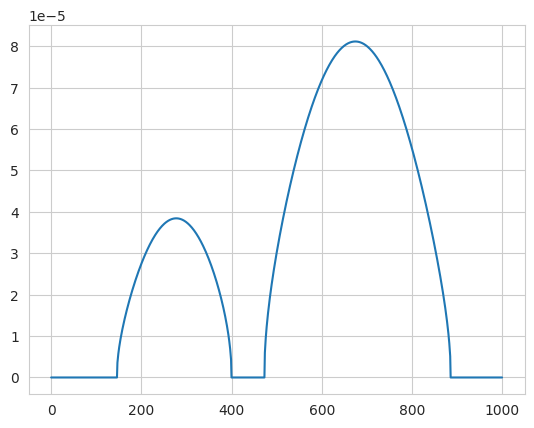

In [ ]:
errorsE = np.zeros(N)
errorsB = np.zeros(N)
for i in range(1,N-1):
  a_1 = vv[i,Iy+1]
  a_2 = vv[i,Iy-1]
  a_3 = vv[i+1,Iy]
  a_4 = vv[i-1,Iy]
  errorsE[i] = np.abs(vv[i,Iy]-min(a_1,a_2,a_3,a_4)-1)

for i in range(1,N-1):
  a_1 = vv[i,Iy+1]
  a_2 = vv[i,Iy-1]
  a_3 = vv[i+1,Iy]
  a_4 = vv[i-1,Iy]
  errorsB[i] = np.abs((.25)*(4*vv[i,Iy]-a_1-a_2-a_3-a_4))

error = [min(errorsE[i], errorsB[i]) for i in range(len(errorsB))]
plt.plot(error)

#plt.plot(errorsE)
#plt.plot(errorsB)

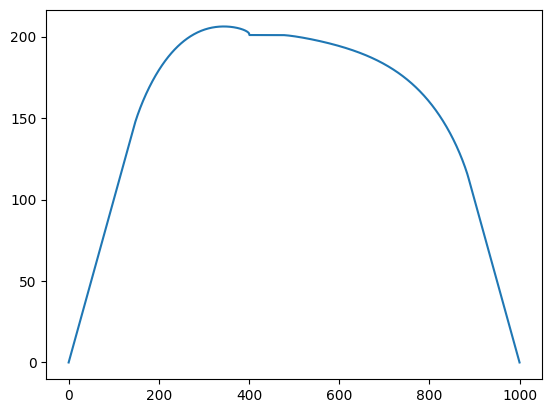

In [ ]:
plt.plot(vv[:,Iy])

#Estrategia.

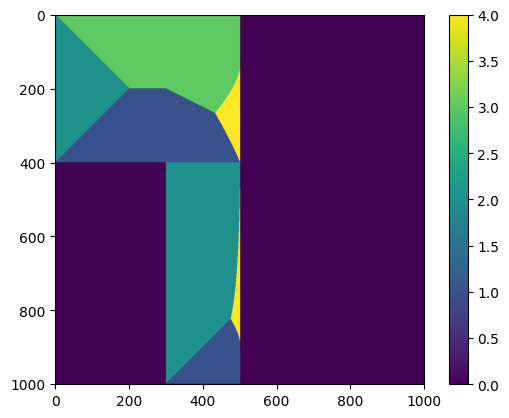

In [ ]:
#Rebuild interphase
for i in range(1,N-1):
  om[i,Iy] = 2

est = Strategy(N,vv,om)
#print(RandomStrategyChange(est,est,N))

plt.imshow(est)
plt.colorbar()

In [ ]:
np.savetxt('estrategia.txt',est,fmt='%d')

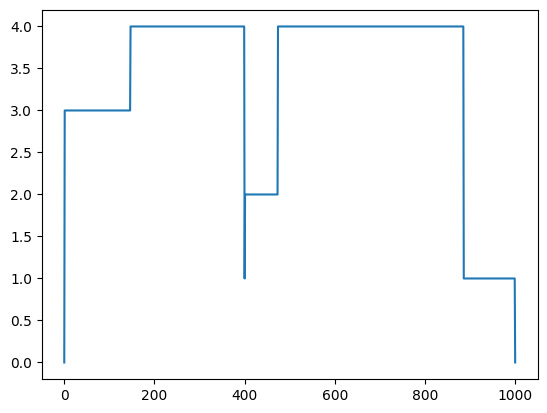

In [ ]:
plt.plot(est[:,Iy])

#Monte Carlo.

In [ ]:
import random

def RandomWalk(x,om,Iy):
  px = x
  py = Iy+1
  while(om[px,py]==3):
    #print(px,py)
    vecino = random.randint(1, 4)
    if(vecino==1):
      px = px-1
    if(vecino==2):
      py = py-1
    if(vecino==3):
      px = px+1
    if(vecino==4):
      py = py+1
  return px, py

IStrategy = np.copy(est[:,Iy])
ICost = np.copy(vv[:,Iy])

def CostoTrayectoria(x,IStrategy,ICost,om,Iy):
  frontier=om[x,Iy]
  cost=1
  while(frontier > 0):
    x,y = RandomWalk(x,om,Iy)
    frontier = om[x,y]
    if(frontier==0):
      return cost
    elif(IStrategy[x]==4):
      cost = cost+1
    elif(IStrategy[x]<4):
      return cost + ICost[x]

print(CostoTrayectoria(120,IStrategy,ICost,om,Iy))

124.0


In [ ]:
costo=np.zeros(1000)
for i in range(1000):
  print(i)
  costo[i] = CostoTrayectoria(300,IStrategy,ICost,om,Iy)
#plt.hist(costo)
#plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0.020904794830999995
0.199763
0.20421900152639916


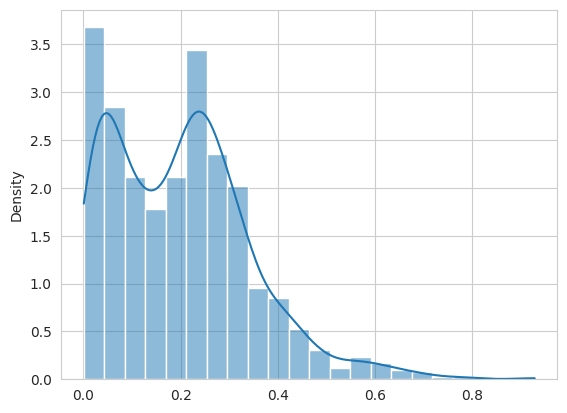

In [ ]:
from numpy.ma.core import mean
from numpy.ma.core import var
import seaborn as sns
import matplotlib.pyplot as py
from seaborn import set_style
set_style("whitegrid")

cost = costo/1000
print(var(cost))
print(mean(cost))
print(ICost[300]/1000)
sns.histplot(data=cost,kde=True,stat="density")
plt.show()


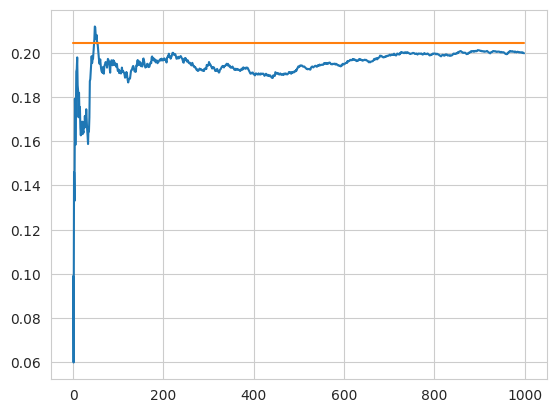

In [ ]:
runing_average = np.zeros(len(cost))
sum = 0
for i in range(len(cost)):
  sum = sum + cost[i]
  runing_average[i] = sum/(i+1)
z = (ICost[300]/1000)*np.ones(len(cost))

py.plot(runing_average)
py.plot(z)

In [ ]:
from scipy.stats import bootstrap

# Wrap the cost array in a list
data_for_bootstrap = [cost]

# Perform bootstrap
bootstrap_result = bootstrap(data_for_bootstrap, np.mean, confidence_level=0.95)
bootstrap_result1 = bootstrap(data_for_bootstrap, np.mean, confidence_level=0.90)

# You can access the confidence interval from the result
low = bootstrap_result.confidence_interval[0]
up = bootstrap_result.confidence_interval[1]

low1 = bootstrap_result1.confidence_interval[0]
up1 = bootstrap_result1.confidence_interval[1]

print(low, up)
print(low1, up1)

0.19091688874663998 0.2091906636189631
0.1922840861404243 0.207382


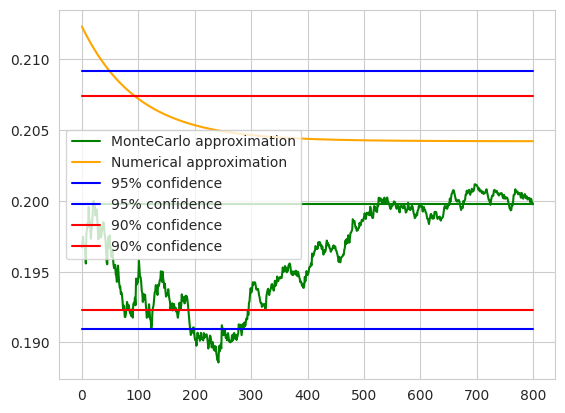

In [ ]:
z1 = low*np.ones(len(cost))
z2 = up*np.ones(len(cost))
z3 = low1*np.ones(len(cost))
z4 = up1*np.ones(len(cost))
z5 = mean(cost)*np.ones(len(cost))

py.plot(runing_average[200:1000], color='green', label='MonteCarlo approximation')
#py.plot(z, color='orange', label='Numerical approximation')
py.plot(val1[200:1000]/1000, color='orange', label='Numerical approximation')
py.plot(z5[200:1000], color='green')
py.plot(z1[200:1000], color='blue', label='95% confidence')
py.plot(z2[200:1000], color='blue', label='95% confidence')
py.plot(z3[200:1000], color='red', label='90% confidence')
py.plot(z4[200:1000], color='red', label='90% confidence')
plt.legend()